### Monte-Carlo sims for comparing D2D and DNN solution vectors



In [1]:
#setup
import numpy as np
import tensorflow as tf

#need to set this to allow eager execution within TF backend (i.e. my custom loss function)
# tf.config.run_functions_eagerly(True) #debug
# tf.data.experimental.enable_debug_mode() 

import matplotlib.pyplot as plt
import scipy.io as sio
import datetime

plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": ["Times"],
    "font.size": 12})

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

print(tf.__version__) #requires tensorflow 2.3

%matplotlib notebook
%load_ext tensorboard
%load_ext autoreload
%autoreload 2
%autosave 180

2023-02-16 09:51:58.177260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 09:51:58.267381: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-16 09:51:58.578753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-16 09:51:58.578789: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


2023-02-16 09:51:59.375047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 09:51:59.399245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 09:51:59.399376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Autosaving every 180 seconds


In [2]:
%%latex
$$
\begin{aligned}
& \text {Table 1.1. Performance on Normalized Training Data }\\
&\begin{array}{cccc}
\hline \hline \text { } & \text { Mean Absolute Error } & \text { Batch Size } & \text { Epochs } & \text {Notes} \\
\hline 

\text{ModelNet40 320k LIDAR (100pts)} & 0.0017 \text { MSE} & 1024 & 100 & \text {Net.kmod } \\

\text{ModelNet40 LIDAR MAIN (100pts)} & 0.0321 & 1024 & 64 & \text {SmallNet.kmod } \\

\text{KITTI 91 skip3 (100pts)} & 0.050 & 128 & 32 & \text {KITTINet100.kmod } \\

\text{KITTI_CARLA 1,3 KITTI 91, 95 (100pts)} & 0.0403 & 1024 & 16 & \text {KITTICARLA100.kmod } \\

\text{combined data (100pts)} & 0.0413 & 1024 & 64 & \text {combinedNet.kmod} \\

\text{Big Compact (100pts)} & 0.0285 \text { MAE} & 1024 & 64 & \text {CompactNet.kmod} \\

\text{ 5, 27, 28 regular (100pts)} & 0.0521 \text { MAE} & 1024 & 16 & \text {ForestNet.kmod} \\

\hline
\end{array}
\end{aligned}
$$

<IPython.core.display.Latex object>

In [33]:
model = tf.keras.models.load_model("CP.kmod") #test
# model = tf.keras.models.load_model("ForestNet.kmod") #test
# model = tf.keras.models.load_model("CompactNet.kmod", custom_objects={'compact_loss': compact_loss}) # trained with custom loss function using ULU^T 
# model = tf.keras.models.load_model("CompactNet.kmod", compile = False)
# model = tf.keras.models.load_model("KITTICARLA100.kmod") #best for KITTI CARLA
# model = tf.keras.models.load_model("KITTINet100.kmod") #best KITTI (trained on combined)
# model = tf.keras.models.load_model("Net.kmod") # best so far for shadowed ModelNet40 point clouds
# model = tf.keras.models.load_model("SmallNet.kmod") # best for uniform sampling dataset
# model = tf.keras.models.load_model("combinedNet.kmod") #KITTI + KITTI_CARLA + ModelNet40
# model = tf.keras.models.load_model("KITTInet.kmod") #50pts, 3cm MAE, trained a while ago...

In [26]:
#load COMPACT test data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

d1 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0095_compact_scan1.npy")
d2 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0095_compact_scan2.npy")
gt = np.load("/media/derm/06EF-127D1/TrainingData/compact/0095_ground_truth.npy")
cgt = np.load("/media/derm/06EF-127D1/TrainingData/compact/0095_compact_ground_truth.npy")
LUT = np.load("/media/derm/06EF-127D1/TrainingData/compact/0095_LUT.npy")
L = np.load("/media/derm/06EF-127D1/TrainingData/compact/0095_L.npy")
U = np.load("/media/derm/06EF-127D1/TrainingData/compact/0095_U.npy")
corn = np.load("/media/derm/06EF-127D1/TrainingData/compact/0095_corn.npy")

# d1 = np.load("training_data/compact_scan1.npy")
# d2 = np.load("training_data/compact_scan2.npy")
# gt = np.load("training_data/ground_truth.npy")
# cgt = np.load("training_data/compact_ground_truth.npy")
# LUT = np.load("training_data/LUT.npy")
# L = np.load("training_data/L.npy")
# U = np.load("training_data/U.npy")
# corn = np.load("training_data/corn.npy")
# d1 = np.append(d1, d1_7, axis = 0)
# d2 = np.append(d2, d2_7, axis = 0)
# gt = np.append(gt, gt_7, axis = 0)
# cgt = np.append(cgt, cgt_7, axis = 0)
# LUT = np.append(LUT, LUT_7, axis = 0)
# L = np.append(L, L_7, axis = 0)
# U = np.append(U, U_7, axis = 0)
# corn = np.append(corn, corn_7, axis = 0)
# d1_7 = d2_7 = gt_7 = cgt_7 = LUT_7 = L_7 = U_7 = corn_7 = None

# d1_3 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown3_compact_scan1.npy")
# d2_3 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown3_compact_scan2.npy")
# gt_3 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown3_ground_truth.npy")
# cgt_3 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown3_compact_ground_truth.npy")
# LUT_3 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown3_LUT.npy")
# L_3 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown3_L.npy")
# U_3 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown3_U.npy")
# corn_3 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown3_corn.npy")
# d1 = np.append(d1, d1_3, axis = 0)
# d2 = np.append(d2, d2_3, axis = 0)
# gt = np.append(gt, gt_3, axis = 0)
# cgt = np.append(cgt, cgt_3, axis = 0)
# LUT = np.append(LUT, LUT_3, axis = 0)
# L = np.append(L, L_3, axis = 0)
# U = np.append(U, U_3, axis = 0)
# corn = np.append(corn, corn_3, axis = 0)
# d1_3 = d2_3 = gt_3 = cgt_3 = LUT_3 = L_3 = U_3 = corn_3 = None


# d1_5 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown2_compact_scan1.npy")
# d2_5 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown2_compact_scan2.npy")
# gt_5 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown2_ground_truth.npy")
# cgt_5 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown2_compact_ground_truth.npy")
# LUT_5 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown2_LUT.npy")
# L_5 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown2_L.npy")
# U_5 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown2_U.npy")
# corn_5 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown2_corn.npy")
# d1 = np.append(d1, d1_5, axis = 0)
# d2 = np.append(d2, d2_5, axis = 0)
# gt = np.append(gt, gt_5, axis = 0)
# cgt = np.append(cgt, cgt_5, axis = 0)
# LUT = np.append(LUT, LUT_5, axis = 0)
# L = np.append(L, L_5, axis = 0)
# U = np.append(U, U_5, axis = 0)
# corn = np.append(corn, corn_5, axis = 0)
# d1_5 = d2_5 = gt_5 = cgt_5 = LUT_5 = L_5 = U_5 = corn_5 = None

# d1_8 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0117_compact_scan1.npy")
# d2_8 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0117_compact_scan2.npy")
# gt_8 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0117_ground_truth.npy")
# cgt_8 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0117_compact_ground_truth.npy")
# LUT_8 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0117_LUT.npy")
# L_8 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0117_L.npy")
# U_8 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0117_U.npy")
# corn_8 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0117_corn.npy")
# d1 = np.append(d1, d1_8, axis = 0)
# d2 = np.append(d2, d2_8, axis = 0)
# gt = np.append(gt, gt_8, axis = 0)
# cgt = np.append(cgt, cgt_8, axis = 0)
# LUT = np.append(LUT, LUT_8, axis = 0)
# L = np.append(L, L_8, axis = 0)
# U = np.append(U, U_8, axis = 0)
# corn = np.append(corn, corn_8, axis = 0)
# d1_8 = d2_8 = gt_8 = cgt_8 = LUT_8 = L_8 = U_8 = corn_8 = None

# #test: add in synthetic ModelNet40 training data
# d1_6 = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_scan1_320k.npy")
# d2_6 = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_scan2_320k.npy")
# gt_6 = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_ground_truth_320k.npy")
# LUT_6 = tf.eye(3,3, batch_shape = [len(gt_6)])
# L_6 = tf.eye(3,3, batch_shape = [len(gt_6)])
# U_6 = tf.eye(3,3, batch_shape = [len(gt_6)])
# d1 = np.append(d1, d1_6, axis = 0)
# d2 = np.append(d2, d2_6, axis = 0)
# gt = np.append(gt, gt_6, axis = 0)
# LUT = np.append(LUT, LUT_6, axis = 0)
# L = np.append(L, L_6, axis = 0)
# U = np.append(U, U_6, axis = 0)
# d1_6= d2_6 = gt_6 = cgt_6 = LUT_6 = L_6 = U_6 = corn_6 = None

# d1_4 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown1_compact_scan1.npy")
# d2_4 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown1_compact_scan2.npy")
# gt_4 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown1_ground_truth.npy")
# cgt_4 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown1_compact_ground_truth.npy")
# LUT_4 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown1_LUT.npy")
# L_4 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown1_L.npy")
# U_4 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown1_U.npy")
# corn_4 = np.load("/media/derm/06EF-127D1/TrainingData/compact/KCtown1_corn.npy")
# d1 = np.append(d1, d1_4, axis = 0)
# d2 = np.append(d2, d2_4, axis = 0)
# gt = np.append(gt, gt_4, axis = 0)
# cgt = np.append(cgt, cgt_4, axis = 0)
# LUT = np.append(LUT, LUT_4, axis = 0)
# L = np.append(L, L_4, axis = 0)
# U = np.append(U, U_4, axis = 0)
# corn = np.append(corn, corn_4, axis = 0)
# d1_4 = d2_4 = gt_4 = cgt_4 = LUT_4 = L_4 = U_4 = corn_4 = None

# d1_2 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0091_compact_scan1.npy")
# d2_2 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0091_compact_scan2.npy")
# gt_2 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0091_ground_truth.npy")
# cgt_2 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0091_compact_ground_truth.npy")
# LUT_2 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0091_LUT.npy")
# L_2 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0091_L.npy")
# U_2 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0091_U.npy")
# corn_2 = np.load("/media/derm/06EF-127D1/TrainingData/compact/0091_corn.npy")
# d1 = np.append(d1, d1_2, axis = 0)
# d2 = np.append(d2, d2_2, axis = 0)
# gt = np.append(gt, gt_2, axis = 0)
# cgt = np.append(cgt, cgt_2, axis = 0)
# LUT = np.append(LUT, LUT_2, axis = 0)
# L = np.append(L, L_2, axis = 0)
# U = np.append(U, U_2, axis = 0)
# corn = np.append(corn, corn_2, axis = 0)
# d1_2= d2_2 = gt_2 = cgt_2 = LUT_2 = L_2 = U_2 = corn_2 = None
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#reshape but don't convert to tensor
points_per_sample = 100          #poitns sammpled from each voxel
tsplit = 0.95 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)
print(np.shape(x_train))
print(np.shape(x_test))

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]

# y_train = gt[:ntrain][:,:,0] #when using compact data
# y_test = gt[ntrain:][:,:,0]
LUT_train = tf.convert_to_tensor(LUT)[:ntrain] 
ULUT_train = tf.matmul(U[:ntrain], LUT_train)

LUT = tf.convert_to_tensor(LUT)[ntrain:]
ULUT_test = tf.matmul(U[ntrain:], LUT)


U = tf.convert_to_tensor(U)[ntrain:]
L = tf.convert_to_tensor(L)[ntrain:]
corn_train = corn[:ntrain]
corn_test = corn[ntrain:]

(151810, 200, 3)
(7990, 200, 3)


## Test training with custom loss function.



In [5]:
# tf.data.experimental.enable_debug_mode()
def augment(points, gt):
    
#     dt = tf.float64
    dt = tf.float32
    
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=dt)

    #shuffle and randomly translate cloud 2 and ground truth
    shift_scale = 0.2 #don't want to make this too large for PC to reach in 1 iter(?)
    shift = tf.cast(tf.concat([shift_scale*tf.random.normal([3])], axis=0) , dt) #may need float64
    points = tf.concat([tf.random.shuffle(points[:100]), tf.random.shuffle(points[100:]) + shift[:3]], axis = 0)
#     gt = tf.concat([(gt[:,0] + shift)[:,None], gt[:,1:] ], axis = -1) #was this
    gt = tf.concat([(gt[:,0] + tf.cast(shift,tf.float32))[:,None], gt[:,1:] ], axis = -1) #when working with modelnet40

    #no shift
#     points = tf.concat([tf.random.shuffle(points[:100]), tf.random.shuffle(points[100:])], axis = 0)
    
    return points, gt

BATCH_SIZE =  1024

y_train_extra = tf.concat([y_train[:, :, None], ULUT_train], 2)
# print(y_train_extra)
# print(x_train)
# y_train_extra = np.append(y_train[:, :, None], ULUT_train, 2)
y_test_extra = tf.concat([y_test[:, :, None], ULUT_test], 2)
# y_test_extra = np.append(y_test[:, :, None], ULUT_test, 2)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_extra))
train_dataset = train_dataset.shuffle(len(x_train)).map(augment).batch(BATCH_SIZE)
print(train_dataset)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_extra))
val_dataset = val_dataset.shuffle(len(x_test)).map(augment).batch(BATCH_SIZE)
print(val_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3, 4), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3, 4), dtype=tf.float32, name=None))>


In [6]:
from network import Net
# from network import bestNet as Net

runLen = 128
BS = 1024

y_train_extra = tf.concat([y_train[:, :, None], ULUT_train], 2)

def compact_loss(y_true_extra, y_pred):
    #Here, we take in LUT as part of y_true that we disect inside this loss function
    y_true = y_true_extra[:,:,0] #ahahahahahah messed up my indexing here!
    ULUT = y_true_extra[:,:,1:]
    
    compact_dnn = tf.matmul(ULUT, y_pred[:,:,None])
    compact_true = tf.matmul(ULUT, y_true[:,:,None])
    loss_compact = (tf.math.reduce_mean(tf.math.abs(compact_dnn - compact_true), axis = 0)**2 )[:,0]    
    loss_compact = tf.math.sqrt(loss_compact)
    
    print(compact_dnn)
    print(y_true[:,:,None])
    
    #take average of compact loss and total loss to try and balance out training
    loss_total = (tf.math.reduce_mean(tf.math.abs(y_pred[:,:,None] - y_true[:,:,None]), axis = 0)**2 )[:,0]
    loss_total = tf.math.sqrt(loss_total)

    loss = (loss_compact + loss_total) / 2
#     loss = loss_compact
#     loss = loss_compact*0.25 + loss_total*(0.75)    
    return loss

def scheduler(epoch, learning_rate):
    part1 = runLen//4
    part2 = 2*runLen//4
    part3 = 3*runLen//4
    if epoch < part1:
        learning_rate = 0.0001
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.00005       
        return learning_rate
    if epoch >= part2 and epoch < part3:
        learning_rate = 0.00001     
        return learning_rate
    if epoch >= part3:
        learning_rate = 0.000001
        return learning_rate

model = Net() #comment out to re-train existing network
model.compile(loss = compact_loss, optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005))
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
cp = tf.keras.callbacks.ModelCheckpoint("CP.kmod", monitor = 'val_loss', save_best_only = True) 

# trace = model.fit(x = x_train, y = y_train_extra, batch_size = BS, 
#                   epochs=runLen, verbose=1, validation_split = 0.2,
#                   shuffle=True, callbacks = [scheduler, cp])

#using tf.data() pipeline instead of simply feeding in np arrays
trace = model.fit(train_dataset, epochs=runLen, validation_data = val_dataset, 
                  verbose=1, callbacks = [scheduler, cp])



Epoch 1/128
Tensor("compact_loss/MatMul:0", shape=(None, 3, 1), dtype=float32)
Tensor("compact_loss/strided_slice_5:0", shape=(None, 3, 1), dtype=float32)
Tensor("compact_loss/MatMul:0", shape=(None, 3, 1), dtype=float32)
Tensor("compact_loss/strided_slice_5:0", shape=(None, 3, 1), dtype=float32)


2022-11-10 17:51:18.936983: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-11-10 17:51:19.220276: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-10 17:51:19.355320: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-10 17:51:29.355721: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 800.00MiB (rounded to 838860800)requested by op model/batch_normalization_3/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-11-10 17:51:29.355758: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2022-11-10 17:51:29.35577

KeyboardInterrupt: 

In [ ]:
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('loss')

In [ ]:
#load ModelNet40 shadowed data
# d1 = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_scan1_320k.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_scan2_320k.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_ground_truth_320k.npy")

#load 100pts KITTI skip3 data
# d1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091_scan1_100pts_skip3.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091_scan2_100pts_skip3.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091_ground_truth_100pts_skip3.npy")

#load 50pts KITTI noskip 
# d1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091v2_scan1_50pts.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091v2_scan2_50pts.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091v2_ground_truth_50pts.npy")
# d1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0071v2_scan1_50pts.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0071v2_scan2_50pts.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0071v2_ground_truth_50pts.npy")

#KITTI + KITTI-CARLA + ModelNet normal training data
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# d1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_CARLA_01_scan1_100pts.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_CARLA_01_scan2_100pts.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_CARLA_01_ground_truth_100pts.npy")
d1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_scan1_100pts.npy")
d2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_scan2_100pts.npy")
gt = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_ground_truth_100pts.npy")

# d1_2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_CARLA_03_scan1_100pts.npy")
# d2_2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_CARLA_03_scan2_100pts.npy")
# gt_2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_CARLA_03_ground_truth_100pts.npy")
# d1 = np.append(d1, d1_2, axis = 0)
# d2 = np.append(d2, d2_2, axis = 0)
# gt = np.append(gt, gt_2, axis = 0)

# d1_4 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091_scan1_100pts_skip3.npy")
# d2_4 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091_scan2_100pts_skip3.npy")
# gt_4 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091_ground_truth_100pts_skip3.npy")
# d1 = np.append(d1, d1_4, axis = 0)
# d2 = np.append(d2, d2_4, axis = 0)
# gt = np.append(gt, gt_4, axis = 0)

# d1_5 = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_scan1_320k.npy")
# d2_5 = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_scan2_320k.npy")
# gt_5 = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_ground_truth_320k.npy")
# d1 = np.append(d1, d1_5, axis = 0)
# d2 = np.append(d2, d2_5, axis = 0)
# gt = np.append(gt, gt_5, axis = 0)

# # d1_3 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0071_scan1_100pts.npy")
# # d2_3 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0071_scan2_100pts.npy")
# # gt_3 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0071_ground_truth_100pts.npy")
# d1_3 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0095_scan1_100pts_skip3.npy")
# d2_3 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0095_scan2_100pts_skip3.npy")
# gt_3 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0095_ground_truth_100pts_skip3.npy")
# d1 = np.append(d1, d1_3, axis = 0)
# d2 = np.append(d2, d2_3, axis = 0)
# gt = np.append(gt, gt_3, axis = 0)

# d1_6 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_scan1_100pts_skip3.npy")
# d2_6 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_scan2_100pts_skip3.npy")
# gt_6 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_ground_truth_100pts_skip3.npy")
# d1 = np.append(d1, d1_6, axis = 0)
# d2 = np.append(d2, d2_6, axis = 0)
# gt = np.append(gt, gt_6, axis = 0)

#forest (straight road)
d1_7 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0027_scan1_100pts.npy")
d2_7 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0027_scan2_100pts.npy")
gt_7 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0027_ground_truth_100pts.npy")
d1 = np.append(d1, d1_7, axis = 0)
d2 = np.append(d2, d2_7, axis = 0)
gt = np.append(gt, gt_7, axis = 0)

#forest (curved road)
d1_7 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0028_scan1_100pts.npy")
d2_7 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0028_scan2_100pts.npy")
gt_7 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0028_ground_truth_100pts.npy")
d1 = np.append(d1, d1_7, axis = 0)
d2 = np.append(d2, d2_7, axis = 0)
gt = np.append(gt, gt_7, axis = 0)
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



# d1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_scan1_100pts.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_scan2_100pts.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_ground_truth_100pts.npy")
# d1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_scan1_100pts_skip3.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_scan2_100pts_skip3.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0005_ground_truth_100pts_skip3.npy")
# d1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0027_scan1_100pts.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0027_scan2_100pts.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0027_ground_truth_100pts.npy")

points_per_sample = 100 #100          #points sampled from each voxel
tsplit = 0.8 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

#randomly shuffle train and test data _______________
np.random.seed(10)
randy = np.linspace(0,np.shape(gt)[0]-1,np.shape(gt)[0]).astype(int)
np.random.shuffle(randy)
scan1 = scan1[randy]
scan2 = scan2[randy]
gt = gt[randy]
#____________________________________________________

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)
print(np.shape(x_train))
# print(np.shape(x_test))

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]

In [4]:
#leddartech dataset
d1 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/church_scan1_100pts.npy")
d2 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/church_scan2_100pts.npy")
gt = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/church_ground_truth_100pts.npy")
d1_2 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/suburban_scan1_100pts.npy")
d2_2 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/suburban_scan2_100pts.npy")
gt_2 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/suburban_ground_truth_100pts.npy")
d1 = np.append(d1, d1_2, axis = 0)
d2 = np.append(d2, d2_2, axis = 0)
gt = np.append(gt, gt_2, axis = 0)
d1_3 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/shops_scan1_100pts.npy")
d2_3 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/shops_scan2_100pts.npy")
gt_3 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/shops_ground_truth_100pts.npy")
d1 = np.append(d1, d1_3, axis = 0)
d2 = np.append(d2, d2_3, axis = 0)
gt = np.append(gt, gt_3, axis = 0)
d1_4 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/bikelane_scan1_100pts.npy")
d2_4 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/bikelane_scan2_100pts.npy")
gt_4 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/bikelane_ground_truth_100pts.npy")
d1 = np.append(d1, d1_4, axis = 0)
d2 = np.append(d2, d2_4, axis = 0)
gt = np.append(gt, gt_4, axis = 0)
d1_5 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/jaywalker_scan1_100pts.npy")
d2_5 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/jaywalker_scan2_100pts.npy")
gt_5 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/jaywalker_ground_truth_100pts.npy")
d1 = np.append(d1, d1_5, axis = 0)
d2 = np.append(d2, d2_5, axis = 0)
gt = np.append(gt, gt_5, axis = 0)
d1_6 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/rainy_scan1_100pts.npy")
d2_6 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/rainy_scan2_100pts.npy")
gt_6 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/rainy_ground_truth_100pts.npy")
d1 = np.append(d1, d1_6, axis = 0)
d2 = np.append(d2, d2_6, axis = 0)
gt = np.append(gt, gt_6, axis = 0)
d1_7 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/overgrown_scan1_100pts.npy")
d2_7 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/overgrown_scan2_100pts.npy")
gt_7 = np.load("/media/derm/06EF-127D3/TrainingData/leddartech/overgrown_ground_truth_100pts.npy")
d1 = np.append(d1, d1_7, axis = 0)
d2 = np.append(d2, d2_7, axis = 0)
gt = np.append(gt, gt_7, axis = 0)

#reshape but don't convert to tensor
points_per_sample = 100 #100 #50          #points sammpled from each voxel
tsplit = 0.8 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)
print(np.shape(x_train))

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]

(727512, 200, 3)


In [ ]:
#load uniformly sampled ModelNet40 data
points_per_sample = 100
# x_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_ModelNet40_x_train.npy')
# y_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_ModelNet40_y_train.npy')[:,:3]
# x_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_ModelNet40_x_test.npy')
# y_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_ModelNet40_y_test.npy')[:,:3]

x_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_simple_ModelNet40_x_train.npy')
y_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_simple_ModelNet40_y_train.npy')[:,:3]
x_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_simple_ModelNet40_x_test.npy')
y_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_simple_ModelNet40_y_test.npy')[:,:3]

# x_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/single_ModelNet40_x_train.npy')
# y_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/single_ModelNet40_y_train.npy')[:,:3]
# x_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/single_ModelNet40_x_test.npy')
# y_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/single_ModelNet40_y_test.npy')[:,:3]

print("x_test", np.shape(x_test))
print("y_test", np.shape(y_test))
print(y_test)

In [5]:
#define functions to convert between spherical and cartesian coordinate representations
def c2s(pts):
    """ converts points from cartesian coordinates to spherical coordinates """
    r = tf.sqrt(pts[:,0]**2 + pts[:,1]**2 + pts[:,2]**2)
    phi = tf.math.acos(pts[:,2]/r)
    theta = tf.math.atan2(pts[:,1], pts[:,0])

    out = tf.transpose(tf.Variable([r, theta, phi]))
    return(out)
def s2c(pts):
    """converts spherical -> cartesian"""

    x = pts[:,0]*tf.math.sin(pts[:,2])*tf.math.cos(pts[:,1])
    y = pts[:,0]*tf.math.sin(pts[:,2])*tf.math.sin(pts[:,1]) 
    z = pts[:,0]*tf.math.cos(pts[:,2])

    out = tf.transpose(tf.Variable([x, y, z]))
    # out = tf.Variable([x, y, z])
    return(out)

### Iterative solution for single test sample

In [7]:
n = int(np.floor(3000*np.random.rand()))
# n = 100
print(n)

c1 = np.array([x_test[n,:points_per_sample,0], x_test[n,:points_per_sample,1], x_test[n,:points_per_sample,2]])
c2 = np.array([x_test[n,points_per_sample:,0], x_test[n,points_per_sample:,1], x_test[n,points_per_sample:,2]])

inputs = x_test[n][None,:]
runlen = 1
corr_sum = np.zeros([1,3]) #init var to store correction contributions
for i in range(runlen):
    correction = model.predict(inputs)[0] #show what the network thinks
#     correction = correction*0.1 #for synthetic matab data only??
#     correction = y_test[n] #show actual solution
    corr_sum += correction
    c1 = np.array([c1[0,:] + correction[0], c1[1,:] + correction[1], c1[2,:] + correction[2]])
    inputs = np.append(c1, c2, axis = 1).T[None,:,:]

print("\n correct soln", y_test[n])
print("\n estiamted soln:", corr_sum)
print("\n error from DNN:", y_test[n] - corr_sum)
mean1 = np.mean(x_test[n,:points_per_sample], axis = 0)
mean2 = np.mean(x_test[n,points_per_sample:], axis = 0)
print("\n error in means",  y_test[n] + (mean1 - mean2))

2391
1/1 [==============================] - 0s 11ms/step

 correct soln [-0.29790786 -2.3209329  -0.13851427]

 estiamted soln: [[-0.21108815 -2.1441679  -0.18347961]]

 error from DNN: [[-0.08681971 -0.17676497  0.04496534]]

 error in means [ 0.28123567 -0.06005764  0.04521681]


In [8]:
#use Vedo to plot inital and transformed point clouds in 3D 
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

plt1 = Plotter(N = 1, axes = 13, bg = (1, 1, 1), interactive = True)
disp = []

#draw scan1 
# disp.append(Points(x_test[n,:points_per_sample].numpy(), c = 'green', r = 5))
disp.append(Points(x_test[n,:points_per_sample], c = 'red', r = 10, alpha = 0.7))

#draw initial scan2
# disp.append(Points(x_test[n,points_per_sample:].numpy(), c = 'red', r = 5))
# disp.append(Points(x_test[n,points_per_sample:], c = 'green', r = 10, alpha = 0.7))

#draw scan2 corrected by DNN
# disp.append(Points(x_test[n, points_per_sample:] - corr_sum, c = "blue", r =10, alpha = 0.7 ))

#Draw arrow for ground truth soln vec
# disp.append(Arrow(mean1 + y_test[n], mean1, c = 'y4', s = 0.002, res = 100)) #arbitrarily start arrow from scan1 center
# disp.append(Arrow(mean2, mean2 - y_test[n], c = 'y4', s = 0.005, res = 100))

#draw ground truth arrow cut short by U and L
# soln_compact = tf.matmul(LUT[n], y_test[n][:, None])
# soln_compact_xyz = tf.matmul(U[n], soln_compact)[:,0]
# soln_compact_xyz = tf.matmul(tf.transpose(U[n]), soln_compact)[:,0]
# print("soln_compact_xyz: \n", soln_compact_xyz)
# disp.append(Arrow( mean2, mean2 - soln_compact_xyz, c = 'p4', s = 0.005, res = 100)) #arbitrarily start arrow from scan1 center

#draw the set of 8 points that defined the voxel boundaries for the keyframe scan
corn_cart = s2c(corn_test[n])
# disp.append(Points(corn_cart, c = 'black', r = 10))

#draw box instead of individual points______________________________
p1, p2, p3, p4, p5, p6, p7, p8 = corn_cart.numpy()
# print(p1)
# print(p2)
lineWidth = 2
c1 = "black"

arc1 = shapes.Line(p1, p2, c = c1, lw = lineWidth) 
disp.append(arc1)
arc2 = shapes.Line(p3, p4, c = c1, lw = lineWidth) #debug
disp.append(arc2)
line1 = shapes.Line(p1, p3, c = c1, lw = lineWidth)
disp.append(line1)
line2 = shapes.Line(p2, p4, c = c1, lw = lineWidth) #problem here
disp.append(line2)
arc3 = shapes.Line(p5, p6, c = c1, lw = lineWidth) #debug
disp.append(arc3)
arc4 = shapes.Line(p7, p8, c = c1, lw = lineWidth) #debug
disp.append(arc4)
line3 = shapes.Line(p5, p7, c = c1, lw = lineWidth)
disp.append(line3)
line4 = shapes.Line(p6, p8, c = c1, lw = lineWidth)
disp.append(line4)
disp.append(shapes.Line(p1,p5, c = c1, lw = lineWidth))
disp.append(shapes.Line(p2,p6, c = c1, lw = lineWidth))
disp.append(shapes.Line(p3,p7, c = c1, lw = lineWidth))
disp.append(shapes.Line(p4,p8, c = c1, lw = lineWidth))
#_____________________________________________________________________

#draw transformed scan2
# disp.append(Points(c1, c = 'blue', r = 5))

plt1.show(disp, "Network Performance Test")
ViewInteractiveWidget(plt1.window)


NameError: name 'corn_test' is not defined

### Run network on all test data 
# RUN TESTS HERE

In [34]:
# for n in range(numToTest):
c1 = np.array([x_test[:,:points_per_sample,0], x_test[:,:points_per_sample,1], x_test[:,:points_per_sample,2]])
c2 = np.array([x_test[:,points_per_sample:,0], x_test[:,points_per_sample:,1], x_test[:,points_per_sample:,2]])
c1 = np.transpose(c1, (1,2,0))
c2 = np.transpose(c2, (1,2,0))

inputs = x_test
# print("c1" , tf.shape(c1))
print("x_test" , tf.shape(x_test))
print("y_test" , tf.shape(y_test))

runlen = 3
corr_sum = np.zeros([tf.shape(x_test)[0].numpy(),1,3]) #init var to store correction contributions
for i in range(runlen):
    correction = model.predict(inputs)[:,None,:] #show what the network thinks
#     correction = correction*0.1 #for synthetic matab data only??
#     correction = y_test[n] #show actual solution
    corr_sum += correction
#     print("corr_sum", tf.shape(corr_sum))
    c1 += correction
#     print("after correction", tf.shape(c1))
    inputs = np.append(c1, c2, axis = 1)#.T
#     print("\n new inputs", tf.shape(inputs))
    
dnn_estimates = corr_sum[:,0,:]
# print("\n correct soln \n", y_test)
# print("\n estiamted soln: \n", dnn_estimates)
# print("\n error from DNN: \n", y_test - dnn_estimates)

# print("\n mean raw DNN error: \n", np.sqrt(np.sum(np.mean(np.abs(y_test - dnn_estimates), axis = 0)**2)))
# print("\n mean raw DNN error: \n", np.sqrt(np.mean(np.abs(y_test - dnn_estimates), axis = 0)**2)) #old
print("\n mean raw DNN error: \n", np.sqrt(np.mean((y_test - dnn_estimates)**2, axis = 0)))

D2D_distance = np.mean(x_test[:,:points_per_sample], axis = 1) - np.mean(x_test[:,points_per_sample:], axis = 1)

print("\n test \n", y_test + D2D_distance)
# print(tf.shape(y_test))
# print("\n mean raw D2D error \n", np.sqrt(np.sum(np.mean(np.abs(y_test + D2D_distance), axis = 0)**2 )))
# print("\n mean raw D2D error \n", np.sqrt(np.mean(np.abs(y_test + D2D_distance), axis = 0)**2 )) #old
print("\n mean raw D2D error \n", np.sqrt(np.mean((y_test + D2D_distance)**2, axis = 0) ))

x_test tf.Tensor([181878    200      3], shape=(3,), dtype=int32)
y_test tf.Tensor([181878      3], shape=(2,), dtype=int32)
5684/5684 [==============================] - 6s 1ms/step

 mean raw DNN error: 
 [0.12298713 0.12337941 0.04999767]

 test 
 [[-0.00784993 -0.00964338  0.06541145]
 [-0.01086438  0.08552206  0.05522541]
 [-0.00824857 -0.03599644 -0.04054027]
 ...
 [ 0.01856078  0.20866811  0.20147012]
 [-0.05900571 -0.03702259  0.02438243]
 [-0.07317426  0.18335432 -0.0227365 ]]

 mean raw D2D error 
 [0.1268657  0.14166628 0.06143866]


251 of 181878 test clouds did not converge


<IPython.core.display.Javascript object>


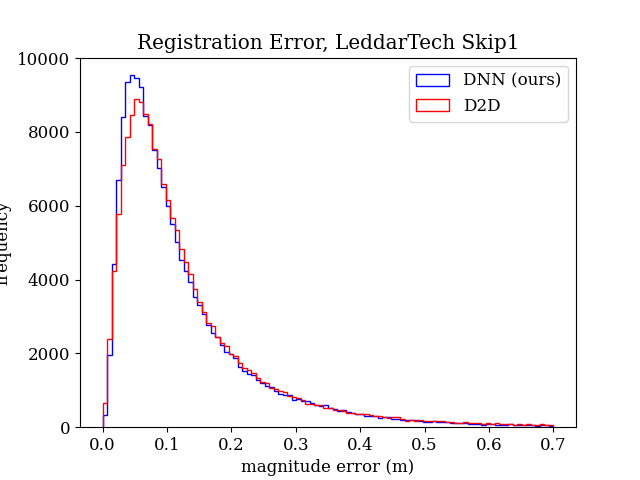

In [35]:
#plot histogram of distribution of errors from DNN (is it even gaussian??)

dnn_error = y_test - dnn_estimates
D2D_error = y_test + D2D_distance
mag_D2D = np.sqrt(D2D_error[:,0]**2 + D2D_error[:,1]**2 + D2D_error[:,2]**2)
mag_DNN = np.sqrt(dnn_error[:,0]**2 + dnn_error[:,1]**2 + dnn_error[:,2]**2)

#get rid of non-converging DNN solns
goodidx = mag_DNN < 1
mag_DNN = mag_DNN[goodidx]
mag_D2D = mag_D2D[goodidx]
print(len(dnn_error) - sum(goodidx), "of", len(dnn_error), "test clouds did not converge")
# print(np.shape(goodidx))

num_bins = 100

#plot on same axis ---------------------------------------
fig, ax = plt.subplots()
# ax.set_title("x component of registration error")
# R = [-0.5,0.5] #range
# ax.hist(dnn_error[:,0], num_bins, R, histtype='step', fill=False, color = (0,0,1), label = 'DNN (ours)')
# ax.hist(D2D_error[:,0], num_bins, R, histtype='step', fill=False, color = (1,0,0), label = 'D2D')
# ax.set_title("Registration Error, KITTI data (skip 3)")
# ax.set_title("Registration Error, Shadowed ModelNet40 Dataset")
# ax.set_title("Registration Error, Uniformly Sampled ModelNet40 Dataset")
ax.set_title("Registration Error, LeddarTech Skip1")
R = [0, 0.7]
ax.hist(mag_DNN, num_bins, R, histtype='step', fill=False, color = (0,0,1), label = 'DNN (ours)')
ax.hist(mag_D2D, num_bins, R, histtype='step', fill=False, color = (1,0,0), label = 'D2D')
# ax.set_xlim([0,0.5])
ax.set_ylabel('frequency')
ax.set_xlabel('magnitude error (m)')
ax.legend(loc = 'best')
#---------------------------------------------------------

# #seprate plots------------------------------------------
# fig, ax = plt.subplots(2,1)
# ax[0].set_ylabel('frequency')
# ax[0].set_xlabel('x component of translation error (m)')
# ax[0].set_title('DNN (ours)')
# ax[0].hist(dnn_error[:,0], num_bins);
# ax[0].set_xlim([-0.5,0.5])

# ax[1].set_title('D2D')
# ax[1].set_ylabel('frequency')
# ax[1].set_xlabel('x component of translation error (m)')
# ax[1].hist(D2D_error[:,0], num_bins*3)
# ax[1].set_xlim([-0.5,0.5])
# #-------------------------------------------------------

<IPython.core.display.Javascript object>


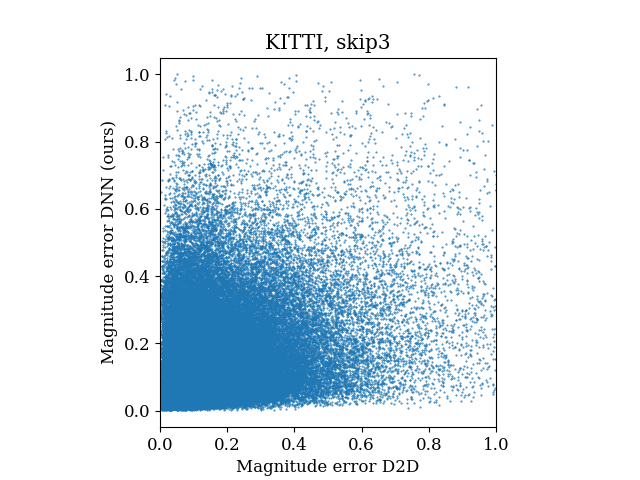


 mean magnitude D2D: 0.13846983

 mean magnitude DNN 0.12798801087354938

 cov mag D2D: 0.1415157327843973

 cov mag DNN: 0.11632224210375065


In [36]:
#plot relationship between error in D2D and error in DNN
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Magnitude error D2D')
# ax.set_xlabel('$\Delta_{D2D}$') #nope
ax.set_xlim([0,1])
ax.set_ylabel('Magnitude error DNN (ours)')
ax.set_title("KITTI, skip3")

ax.scatter(mag_D2D, mag_DNN, alpha = 1, s = 0.2)

c = np.cov(mag_D2D, mag_DNN)

print("\n mean magnitude D2D:", np.mean(mag_D2D))
print("\n mean magnitude DNN", np.mean(mag_DNN))
print("\n cov mag D2D:", np.sqrt(c)[0,0])
print("\n cov mag DNN:", np.sqrt(c)[1,1])

<IPython.core.display.Javascript object>


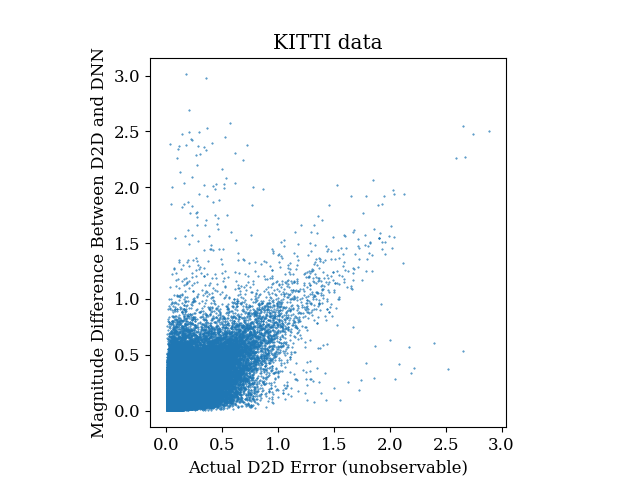

[[0.02060737 0.01328516]
 [0.01328516 0.02136062]]


In [37]:
#demonstrate using |D2D-DNN| as a monitor statistic

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Actual D2D Error (unobservable)')
ax.set_ylabel('Magnitude Difference Between D2D and DNN')
# ax.set_xlabel('$\Delta_{D2D}$') #nope
# ax.set_xlim([0,1])
ax.set_title("KITTI data")

# print(D2D_distance[:10])
# print(dnn_estimates[:10])
Diff= dnn_estimates  +  D2D_distance
mag_Diff = np.sqrt(Diff[:,0]**2 + Diff[:,1]**2 + Diff[:,2]**2)

D2D_error = y_test + D2D_distance
mag_D2D = np.sqrt(D2D_error[:,0]**2 + D2D_error[:,1]**2 + D2D_error[:,2]**2)
# print(y_test)
# print(D2D_distance)
# print(D2D_error)

ax.scatter(mag_D2D, mag_Diff, alpha = 1, s = 0.2)
# ax.plot(np.linspace(0,1,50),np.linspace(0,1,50), color = (1,0,0)) #plot y=x (for debug)


c = np.cov(mag_D2D, mag_Diff)
print(c)

In [13]:
#consider magnitude of error projected in compact directions

#use LUT to get compact axis of DNN solution vec for each trial
#was this
# dnn_compact = tf.matmul(LUT, dnn_estimates[:,:,None])
# dnn_compact_xyz = tf.matmul(U, dnn_compact)
# truth_compact = tf.matmul(LUT, y_test[:,:,None])
# truth_compact_xyz = tf.matmul(U, truth_compact) 
#new
dnn_compact_xyz = tf.matmul(ULUT_test, dnn_estimates[:,:,None])
# print(tf.shape(dnn_compact))
truth_compact_xyz = tf.matmul(ULUT_test, y_test[:,:,None])
# print(tf.shape(truth_compact_xyz))

# # #old
# #consider all
# error_DNN_compact = np.sqrt( np.mean(np.abs(truth_compact_xyz - dnn_compact_xyz), axis = 0)**2 )[:,0] #wrong(?)
# # ignore cases where DNN explodes...
# # error_DNN_compact = np.sqrt( np.mean(np.abs(truth_compact_xyz[goodidx] - dnn_compact_xyz[goodidx]), axis = 0)**2 )[:,0]
# print("\n mean compact error DNN: \n", error_DNN_compact)
# DNN_total = np.sqrt(error_DNN_compact[0]**2 + error_DNN_compact[1]**2 + error_DNN_compact[2]**2)
# print("total mag DNN", DNN_total)

#RMSE
d_dnn = (truth_compact_xyz - dnn_compact_xyz)[:,:,0] #get difference for each xyz component for each trial
# print(d_dnn)
mag_d_dnn = np.sqrt(d_dnn[:,0]**2 + d_dnn[:,1]**2 + d_dnn[:,2]**2) #get magnitude of error in solution
# print(mag_d_dnn)
# print(np.mean(mag_d_dnn))
RMSE_DNN_compact = np.sqrt(np.mean(mag_d_dnn**2))
print("\n mean compact error DNN:", RMSE_DNN_compact)

# #old
# # error_D2D_compact = np.sqrt(np.sum( np.mean(np.abs(truth_compact_xyz + d2d_compact_xyz), axis = 0)**2 ))
# #for distrubution means distance
# d2d_compact = tf.matmul(LUT, D2D_distance[:,:,None])
# d2d_compact_xyz = tf.matmul(U, d2d_compact)
# truth_compact = tf.matmul(LUT, y_test[:,:,None])
# truth_compact_xyz = tf.matmul(U, truth_compact)
# error_D2D_compact = np.sqrt(np.mean(np.abs(truth_compact_xyz + d2d_compact_xyz), axis = 0)**2 )[:,0]
# # error_D2D_compact = np.sqrt(np.mean(np.abs(truth_compact_xyz[goodidx] + d2d_compact_xyz[goodidx]), axis = 0)**2 )[:,0] #ignore DNN exploding
# print("\n mean compact error D2D: \n", error_D2D_compact)
# D2D_total = np.sqrt(error_D2D_compact[0]**2 + error_D2D_compact[1]**2 + error_D2D_compact[2]**2)
# print("total mag D2D", D2D_total)

#RMSE
d2d_compact_xyz = tf.matmul(ULUT_test, D2D_distance[:,:,None])
d_d2d = (truth_compact_xyz + d2d_compact_xyz)[:,:,0]
mag_d_d2d = np.sqrt(d_d2d[:,0]**2 + d_d2d[:,1]**2 + d_d2d[:,2]**2)
RMSE_D2D_compact = np.sqrt(np.mean(mag_d_d2d**2))
print("\n mean compact error D2D:", RMSE_D2D_compact)


fig, ax  = plt.subplots()
ax.scatter(mag_d_d2d, mag_d_dnn, s = 0.2)

NameError: name 'ULUT_test' is not defined

In [ ]:
s2c(corn_test[n])

In [ ]:
I = 10
print(y_train[I])
print(ULUT_train[I] @ y_train[I][:,None])
